<a href="https://colab.research.google.com/github/OH1107/Goyang-Public-bicycles-EDA/blob/master/Goyang_Public_bicycles_EDA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 준비

## (1) 구글 드라이브 연동

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  

# path to your project on Google Drive
MY_GOOGLE_DRIVE_PATH = '/content/gdrive/My Drive/Colab Notebooks/고양시/data'
PROJECT_PATH = join('/content/gdrive', MY_GOOGLE_DRIVE_PATH)

In [3]:
%cd "{PROJECT_PATH}"
!ls

/content/gdrive/My Drive/Colab Notebooks/고양시/data
 01.운영이력.csv			     20.고양시_버스정류소.csv
 02.자전거스테이션.csv			     21.버스_정류장별_승하차_정보.csv
 03.꽃박람회일정.csv			     22.주차장정보.csv
 04.KINTEX행사일정.csv			     23.고양시덕양구_DEM.img
 05.기상정보.csv			     24.고양시일산동구_DEM.img
'06.인구(거주)분포도(100M_X_100M).geojson'   25.고양시일산서구_DEM.img
 07.인구통계.csv			    '26.고양시 공연장 박물관 정보.csv'
'08.행정경계(시군구).geojson'		    '27.고양시 체육시설 현황 정보.csv'
'09.행정경계(읍면동).geojson'		     28.코드정의서.xlsx
'10.도시계획(공간시설).geojson'		    '29.지하철 역별 이용객수.csv'
'11.도시계획(공공문화체육시설).geojson'      30.고양시_덕양구_고도.geojson
'12.도시계획(교통시설).geojson'		     31.고양시_일산동구_고도.geojson
'13.용도지역지구(습지보호지역).geojson'      32.고양시_일산서구_고도.geojson
 14.고양시_지적도.geojson		     33.고양시_인도

## (2) 패키지 호출

In [4]:
!pip install geopandas
!pip install geojson
!pip install haversine     # 좌표간 거리 구하기
!pip install tqdm

     |████████████████████████████████| 972kB 8.0MB/s 
     |████████████████████████████████| 14.7MB 243kB/s 
     |████████████████████████████████| 10.9MB 53.4MB/s 


In [5]:
import json
import pandas as pd
import numpy as np
import geojson
from haversine import haversine
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import missingno as mnso
from shapely.geometry import shape, GeometryCollection, Point
import geopandas as gpd
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
import matplotlib.font_manager as fm
from pandas.plotting import register_matplotlib_converters
import matplotlib as mpl

fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()
#mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')
#fm._rebuild()

In [7]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# matplotlib 폰트를 Nanum 폰트로 지정
plt.rc('font', family='NanumGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (47.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

## (6) 피프틴 사용량

In [8]:
df_1 = pd.read_csv('01.운영이력.csv')

- 데이터 정의서
  + LEAS_NO : 대여번호
  + LEAS_DATE : 대여 시간
  + LEAS_STATION : 대여 스테이션 번호
  + LEAS_DEF_NO : 대여 거치대 번호
  + RTN_DATE : 반납 시간
  + RTN_STATION : 반납 스테이션 번호
  + RTN_DEF_NO : 반납 거치대 번호
  + RTN_PROCESS : 관제반납구분값
    + (01: 관제반납 / 02: 관리자반납 / 03: 관리자반출 / 04: 타 사용자 반납 / 05: 다른 사용자 반출)
  + TRNV_QTY : 추정 이동 거리(m)
  + MEMB_DIV : 회원 구분(비회원은 99이며 나머지는 정회원)
  + MEMB_NO : 회원 번호
  + TEMP_MEMB_NO : 비회원 번호
  + BIKE_TAG : 자전거 번호

In [10]:
df_1.head()

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS
0,15945541,2,2017-01-01 00:00:41,213,18,2017-01-01 00:13:52,260,17,0.0,6,164203,0.0,1A844000000BB7,NaN
1,15945542,2,2017-01-01 00:01:03,231,4,2017-01-01 00:50:24,231,17,31039.0,1,187551,0.0,1A844000000494,NaN
2,15945543,2,2017-01-01 00:01:50,119,14,2017-01-01 01:01:50,0,0,NaN,12,168994,0.0,1A844000000533,1.0
3,15945544,2,2017-01-01 00:02:09,121,17,2017-01-01 00:15:58,133,14,15490.0,12,183971,0.0,1A844000000731,NaN
4,15945545,2,2017-01-01 00:03:32,320,29,2017-01-01 00:18:44,259,27,0.0,12,167475,0.0,1A84400000F343,NaN


- 데이터 결측치 확인

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


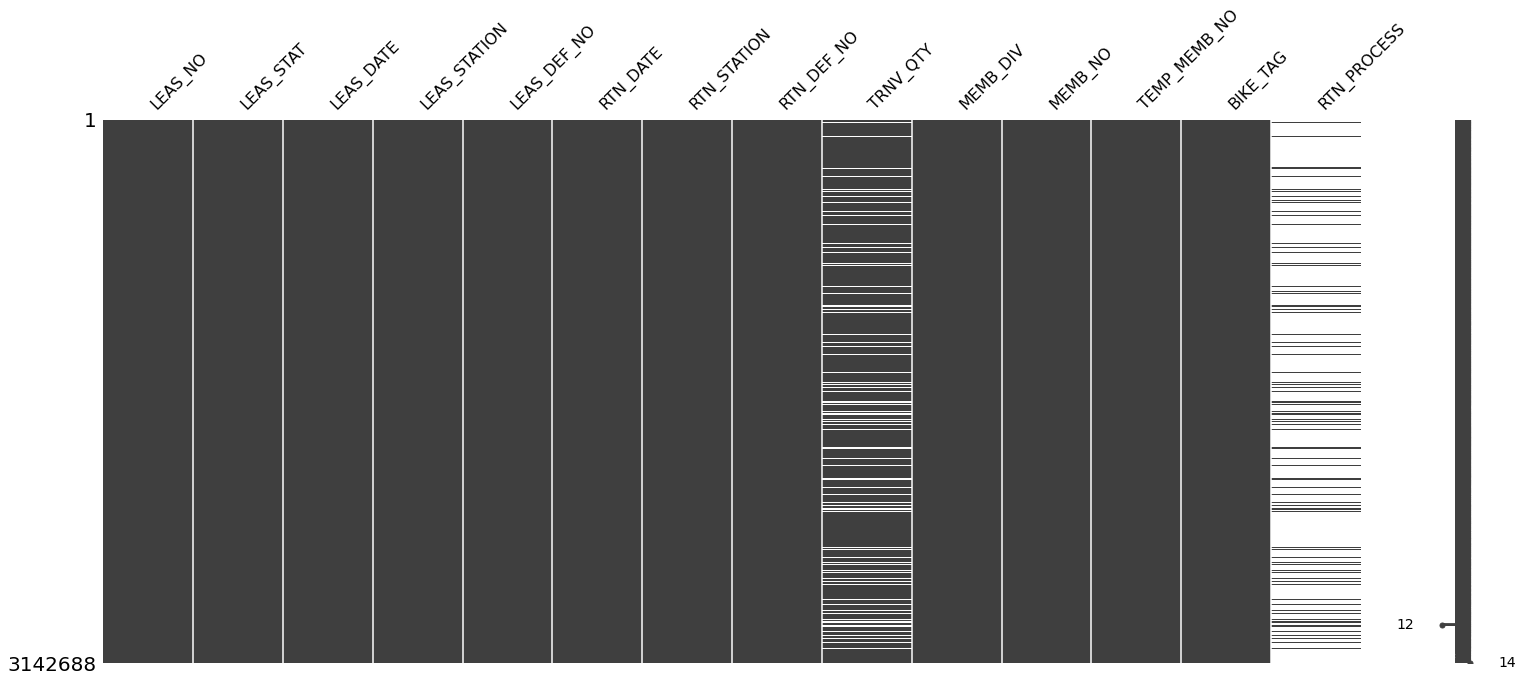

In [9]:
msno.matrix(df_1)
plt.show()

- TRNV_QTY(추정 이동 거리) 값과 RTN_PROCESS(관제반납구분) 값의 데이터에 결측치가 상당수 존재하는 것을 확인할 수 있다. 

### (6).1 스테이션 월별 사용량

- 대여 일시와 반납 일시로부터 월별 데이터를 추출한다.

In [11]:
#대여 일시를 월별로 분류
df_1['LEAS_MONTH_ONLY']= df_1['LEAS_DATE'].map(lambda x: x.split(' ')[0][:-3])

#반납 일시를 월별로 분류
df_1['RTN_MONTH_ONLY']= df_1['RTN_DATE'].map(lambda x: x.split(' ')[0][:-3])
df_1.head()

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,LEAS_MONTH_ONLY,RTN_MONTH_ONLY
0,15945541,2,2017-01-01 00:00:41,213,18,2017-01-01 00:13:52,260,17,0.0,6,164203,0.0,1A844000000BB7,NaN,2017-01,2017-01
1,15945542,2,2017-01-01 00:01:03,231,4,2017-01-01 00:50:24,231,17,31039.0,1,187551,0.0,1A844000000494,NaN,2017-01,2017-01
2,15945543,2,2017-01-01 00:01:50,119,14,2017-01-01 01:01:50,0,0,NaN,12,168994,0.0,1A844000000533,1.0,2017-01,2017-01
3,15945544,2,2017-01-01 00:02:09,121,17,2017-01-01 00:15:58,133,14,15490.0,12,183971,0.0,1A844000000731,NaN,2017-01,2017-01
4,15945545,2,2017-01-01 00:03:32,320,29,2017-01-01 00:18:44,259,27,0.0,12,167475,0.0,1A84400000F343,NaN,2017-01,2017-01


- LEAS_STATION, RTN_STATION 데이터 중 '0, 999, 998, 992'는 제외하도록 한다.
  - 제외하는 이유는 다음과 같다.
    - 수리로 인해 스테이션 반납이 아닌 관제 센터로 반납된 경우
    - 분실로 인해 반납이 이뤄지지 않은 경우
    - 내부 테스트를 위해 가상으로 등록된 데이터인 경우

In [14]:
# 반납 스테이션 0, 999, 998 제외
case = df_1['RTN_STATION'].isin([0, 999, 998, 992])
df_1_copy=df_1[~case]
df_1_copy.head()

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,LEAS_MONTH_ONLY,RTN_MONTH_ONLY
0,15945541,2,2017-01-01 00:00:41,213,18,2017-01-01 00:13:52,260,17,0.0,6,164203,0.0,1A844000000BB7,NaN,2017-01,2017-01
1,15945542,2,2017-01-01 00:01:03,231,4,2017-01-01 00:50:24,231,17,31039.0,1,187551,0.0,1A844000000494,NaN,2017-01,2017-01
3,15945544,2,2017-01-01 00:02:09,121,17,2017-01-01 00:15:58,133,14,15490.0,12,183971,0.0,1A844000000731,NaN,2017-01,2017-01
4,15945545,2,2017-01-01 00:03:32,320,29,2017-01-01 00:18:44,259,27,0.0,12,167475,0.0,1A84400000F343,NaN,2017-01,2017-01
5,15945546,2,2017-01-01 00:03:40,309,8,2017-01-01 00:10:50,210,3,0.0,99,0,3185081.0,1A84400000F505,NaN,2017-01,2017-01


- 대여(스테이션, 월별) 횟수를 확인한다.

In [15]:
leas_count=df_1_copy.groupby(['LEAS_STATION', 'LEAS_MONTH_ONLY']).count().max(axis=1).reset_index()
leas_count.columns=['Station_ID','DATE','LEAS_COUNT']
leas_count

,Station_ID,DATE,LEAS_COUNT
0,101,2017-01,73
1,101,2017-02,68
2,101,2017-03,186
3,101,2017-04,282
4,101,2017-05,385
...,...,...,...
5379,992,2019-08,34
5380,992,2019-09,27
5381,992,2019-10,12
5382,992,2019-11,21


- 반납(스테이션, 월별) 횟수를 확인한다.

In [16]:
rtn_count=df_1_copy.groupby(['RTN_STATION', 'RTN_MONTH_ONLY']).count().max(axis=1).reset_index()
rtn_count.columns=['Station_ID','DATE','RTN_COUNT']
rtn_count

,Station_ID,DATE,RTN_COUNT
0,101,2017-01,109
1,101,2017-02,89
2,101,2017-03,204
3,101,2017-04,372
4,101,2017-05,500
...,...,...,...
5348,350,2019-12,37
5349,351,2019-09,5
5350,351,2019-10,112
5351,351,2019-11,140


- 하나의 데이터프레임으로 묶어주도록 한다.

In [ ]:
# 전 데이터를 불러와야함...... 이 부분은 다시 추가하도록 해야겠다.
station_leas_rtn=pd.merge(leas_count,station[['Station_ID','gu','dong','STATION_NAME']],on='Station_ID',how='left')
station_leas_rtn=pd.merge(station_leas_rtn,rtn_count,on=['Station_ID','DATE'],how='left')
station_leas_rtn=station_leas_rtn[['gu','dong','Station_ID','DATE','LEAS_COUNT','RTN_COUNT']]
station_leas_rtn